# Return Period for La ReUnion Best Track Data

This notebook reviews the return period using La ReUnion Best Track data

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime
from shapely.geometry import Point
import numpy as np

In [3]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
adm0_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)

<Axes: >

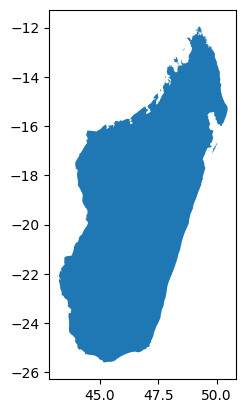

In [4]:
gdf_adm0.plot()

In [5]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    Path(AA_DATA_DIR)
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

In [31]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(lambda x: -x if x > 0 else x)
cyclone_tracks_buffer = cyclone_tracks.copy()
cyclone_tracks_buffer["RMW_km"] = cyclone_tracks_buffer["RMW (mn)"] * 1.852

In [66]:
cyclone_tracks_buffer["RMW_km"] = (
    cyclone_tracks_buffer["RMW_km"].fillna(0.001).replace(0, 0.001)
)

In [62]:
# Create 'geometry' column in cyclone_tracks GeoDataFrame using Lat/Lon for the points
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)

# Convert cyclone_tracks DataFrame to GeoDataFrame
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)

# Create 'geometry' column in cyclone_tracks_buffer GeoDataFrame
cyclone_tracks_buffer["geometry"] = cyclone_tracks_buffer.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)

# Convert cyclone_tracks_buffer DataFrame to GeoDataFrame
cyclone_tracks_gdf_buffer = gpd.GeoDataFrame(
    cyclone_tracks_buffer, geometry="geometry", crs="EPSG:4326"
)

# Create buffers for the cyclone tracks using the RMW_km column, converting km to degrees
# Conversion factor for degrees per km at the equator: 1 degree = 110.574 km
cyclone_tracks_gdf_buffer["geometry"] = cyclone_tracks_gdf_buffer.geometry.buffer(
    cyclone_tracks_gdf_buffer["RMW_km"] / 110.574
)

C:\Users\pauni\AppData\Local\Temp\ipykernel_45324\191589508.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cyclone_tracks_gdf_buffer["geometry"] = cyclone_tracks_gdf_buffer.geometry.buffer(


In [63]:
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, gdf_adm0, how="inner", predicate="intersects"
)

cyclone_tracks_sel_buffer = gpd.sjoin(
    cyclone_tracks_gdf_buffer, gdf_adm0, how="inner", predicate="intersects"
)

<Axes: >

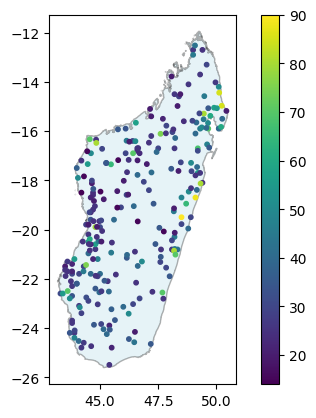

In [64]:
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
cyclone_tracks_sel.plot(ax=ax, column="Max wind (kt)", markersize=10, legend=True)

<Axes: >

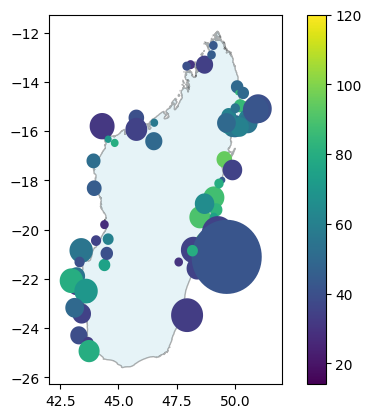

In [65]:
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
cyclone_tracks_sel_buffer.plot(
    ax=ax, column="Max wind (kt)", markersize=10, legend=True
)

In [53]:
cyclone_tracks_sel["Name"].unique()

array(['ALIFREDY', 'HONORININA', 'CALIDERA', 'DOAZA', 'FILAO', 'HELY',
       'CALASANJY', 'IANA', 'ALIBERA', 'CYNTHIA', 'G19091', 'BRYNA',
       'ELIZABETHA', 'DESSILIA', 'GRACIA', 'HUTELLE', 'IONIA', 'DAISY',
       'GERALDA', 'JULITA', 'LITANNE', 'CHRISTELLE', 'BONITA', 'FABRIOLA',
       'GRETELLE', 'JOSIE', 'BELTANE', 'ASTRIDE', 'ELINE', 'GLORIA',
       'HUDAH', 'DERA', 'CYPRIEN', 'GUILLAUME', 'KESINY', 'FARI',
       'JAPHET', 'CELA', 'ELITA', 'GAFILO', 'FELAPI', '720052006',
       'BOLOETSE', 'BONDO', 'CLOVIS', 'INDLALA', 'JAYA', 'FAME', 'IVAN',
       'JOKWE', 'FANELE', 'JADE', 'FAMI', 'HUBERT', 'BINGIZA', 'CHANDA',
       'GIOVANNA', 'IRINA', 'HARUNA', 'DELIWE', '820132014', 'HELLEN',
       'CHEDZA', '1120142015', 'ENAWO', 'AVA', 'ELIAKIM', 'BELNA',
       'DIANE', 'FRANCISCO', 'CHALANE', 'ELOISE', 'IMAN', 'ANA',
       'BATSIRAI', 'DUMAKO', 'EMNATI', 'GOMBE', 'JASMINE', 'CHENESO',
       'FREDDY'], dtype=object)

In [54]:
cyclone_tracks_sel.columns

Index(['Name', 'Depr Num', 'Day', 'Month', 'Year', 'UTC', 'Lat', 'Lon',
       'Accu (mn)', 'Max wind (kt)', 'Gust (kt)', 'RMW (mn)', 'MSLP (hPa)',
       'FT', 'Ci', '28kt_NE_mn', '28kt_SE_mn', '28kt_SW_mn', '28kt_NW_mn',
       '34kt_NE_mn', '34kt_SE_mn', '34kt_SW_mn', '34kt_NW_mn', '48kt_NE_mn',
       '48kt_SE_mn', '48kt_SW_mn', '48kt_NW_mn', '64kt_NE_mn', '64kt_SE_mn',
       '64kt_SW_mn', '64kt_NW_mn', 'geometry', 'index_right', 'ADM0_PCODE',
       'ADM0_EN', 'SOURCE'],
      dtype='object')

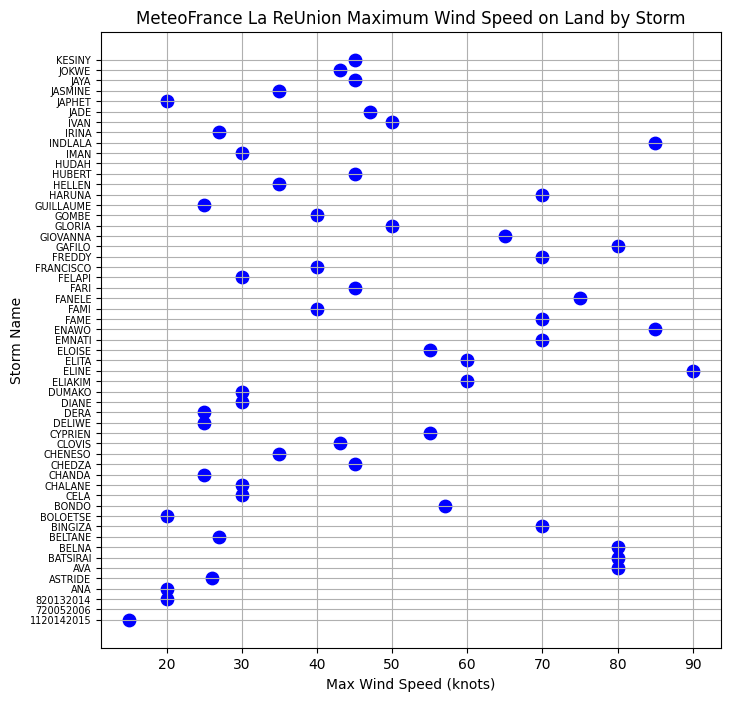

In [78]:
max_values = (
    cyclone_tracks_sel[cyclone_tracks_sel["Year"] >= 1998]
    .groupby("Name")["Max wind (kt)"]
    .max()
    .reset_index()
)

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(8, 8))
plt.scatter(
    max_values["Max wind (kt)"],
    max_values["Name"],
    color="blue",
    s=80,
    label="Max Wind Speed",
)
plt.yticks(fontsize=7)  # Adjust the fontsize value as needed
# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed (knots)")
plt.title("MeteoFrance La ReUnion Maximum Wind Speed on Land by Storm")
plt.grid(True)
plt.show()

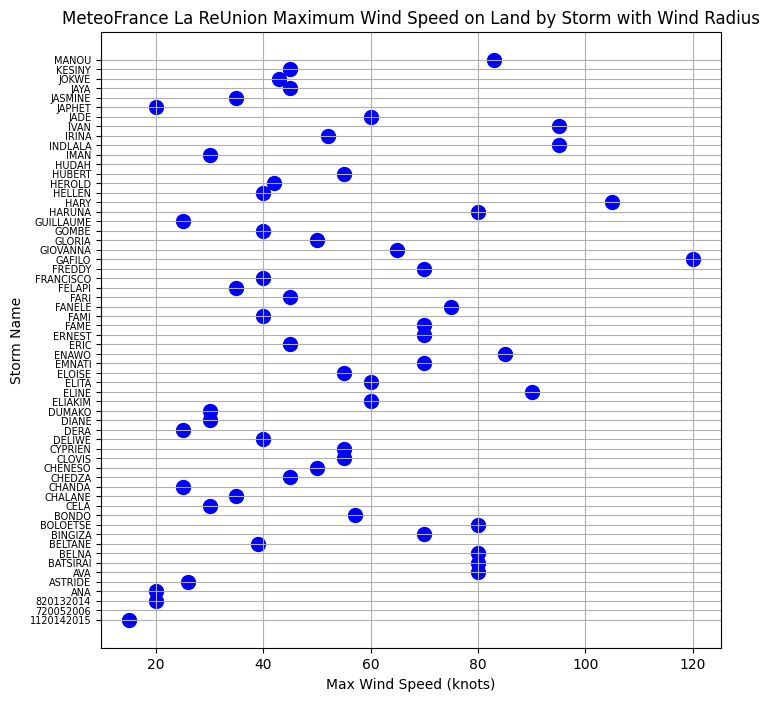

In [79]:
max_values = (
    cyclone_tracks_sel_buffer[cyclone_tracks_sel_buffer["Year"] >= 1998]
    .groupby("Name")["Max wind (kt)"]
    .max()
    .reset_index()
)

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(8, 8))
plt.scatter(
    max_values["Max wind (kt)"],
    max_values["Name"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)
plt.yticks(fontsize=7)  # Adjust the fontsize value as needed
# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed (knots)")
plt.title("MeteoFrance La ReUnion Maximum Wind Speed on Land by Storm with Wind Radius")
plt.grid(True)
plt.show()

In [18]:
def calculate_storm_return_period_la_reunion(df, wind_speed_kmh, start_year):

    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Ensure UTC is formatted as a two-digit hour
    df["UTC"] = df["UTC"].apply(lambda x: f"{int(x):02}")
    # Create a datetime column from separate date and time columns
    df["ISO_TIME"] = pd.to_datetime(
        df[["Year", "Month", "Day", "UTC"]].astype(str).agg(" ".join, axis=1)
    )

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].dt.year

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[(df["year"] >= start_year) & (df["Max wind (kt)"] >= speed_knots)]

    # Count unique storms
    unique_storms = df_filtered["Name"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2023 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh} km/h is 1-in-{round(combined_return_period, 1)} years."
    )

In [90]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_gdf, wind_speed_kmh=118, start_year=1985
)

The combined return period of storms over 118 km/h is 1-in-0.2 years.


In [92]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_gdf_buffer, wind_speed_kmh=118, start_year=1985
)

The combined return period of storms over 118 km/h is 1-in-0.2 years.


In [93]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_gdf, wind_speed_kmh=166, start_year=1985
)

The combined return period of storms over 166 km/h is 1-in-0.3 years.


In [94]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_gdf_buffer, wind_speed_kmh=166, start_year=1985
)

The combined return period of storms over 166 km/h is 1-in-0.3 years.


In [95]:
cyclone_tracks_sel.drop(columns=["index_right"], inplace=True)

KeyError: "['index_right'] not found in axis"

In [96]:
# Function to calculate the return period for a given wind speed threshold and buffer zone
def calculate_storm_return_period_buffer(
    df, gdf_adm0_buffer, wind_speed_knots, start_year
):
    # Perform spatial join between storm points and buffer zone (gdf_adm0_buffer)
    df_sel = gpd.sjoin(
        df, gdf_adm0_buffer, how="inner", predicate="intersects", lsuffix=""
    )
    df_sel_ = df_sel.sort_values("ISO_TIME")

    # Extract the year from the 'ISO_TIME' column
    df_sel_["year"] = df_sel_["ISO_TIME"].apply(lambda x: x.year)

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df_sel_[
        (df_sel_["year"] >= start_year) & (df_sel_["Max wind (kt)"] >= wind_speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["Name"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2023 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms
    return round(combined_return_period, 1)

C:\Users\pauni\AppData\Local\Temp\ipykernel_45324\2280609680.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm0_buffer["geometry"] = gdf_adm0.geometry.buffer(
C:\Users\pauni\AppData\Local\Temp\ipykernel_45324\2280609680.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm0_buffer["geometry"] = gdf_adm0.geometry.buffer(
C:\Users\pauni\AppData\Local\Temp\ipykernel_45324\2280609680.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_adm0_buffer["geometry"] = gdf_adm0.geometry.buffer(
C:\Users\pauni\AppData\Local\Temp\ipykernel_45324\2280609680.py:12: UserW

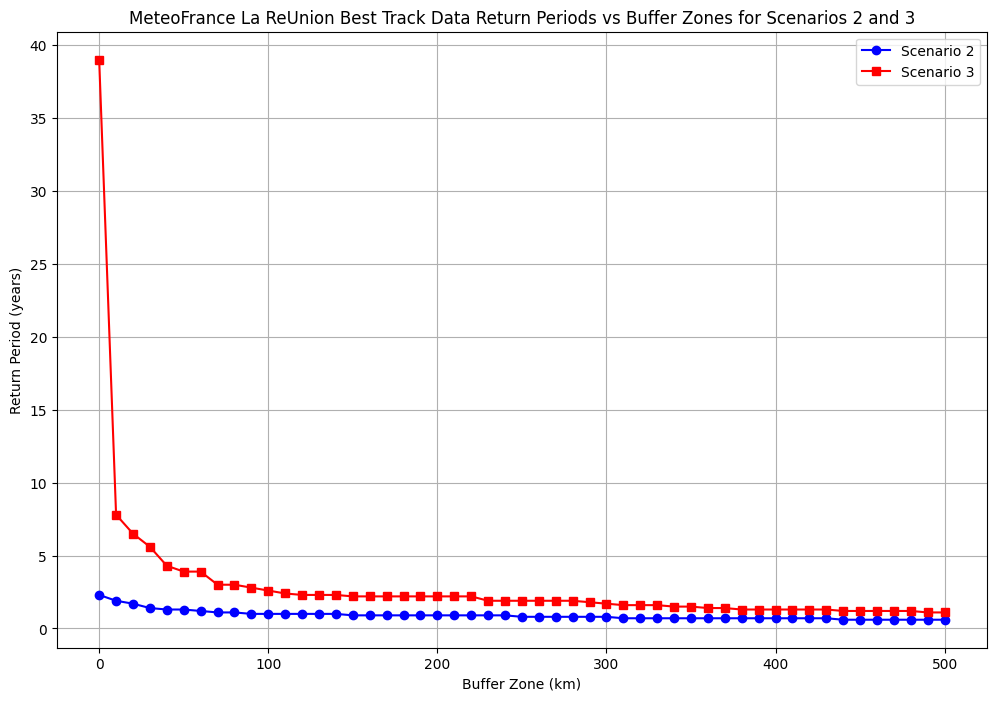

In [99]:
# Sample buffers in kilometers
buffers = np.arange(0, 501, 10)

# Lists to store the return periods for 64 knots and 90 knots thresholds
return_periods_64_knots = []
return_periods_90_knots = []

# Iterate through buffers and calculate return periods for both thresholds
for buffer in buffers:
    # Create buffer around gdf_adm0 with the given distance
    gdf_adm0_buffer = gdf_adm0.copy()
    gdf_adm0_buffer["geometry"] = gdf_adm0.geometry.buffer(
        buffer / 110.574
    )  # Buffer in meters

    # Calculate return period for 64 knots threshold
    return_64_knots = calculate_storm_return_period_buffer(
        cyclone_tracks_gdf, gdf_adm0_buffer, wind_speed_knots=64, start_year=1985
    )  # 118.5 km/h = 64 knots

    # Calculate return period for 90 knots threshold
    return_90_knots = calculate_storm_return_period_buffer(
        cyclone_tracks_gdf, gdf_adm0_buffer, wind_speed_knots=90, start_year=1985
    )  # 166.7 km/h = 90 knots

    # Store the return periods
    return_periods_64_knots.append(return_64_knots)
    return_periods_90_knots.append(return_90_knots)

# Plotting the return periods for both 64 knots and 90 knots
plt.figure(figsize=(12, 8))
plt.plot(
    buffers,
    return_periods_64_knots,
    marker="o",
    label="Scenario 2",
    color="blue",
)
plt.plot(
    buffers,
    return_periods_90_knots,
    marker="s",
    label="Scenario 3",
    color="red",
)

plt.title(
    "MeteoFrance La ReUnion Best Track Data Return Periods vs Buffer Zones for Scenarios 2 and 3"
)
plt.xlabel("Buffer Zone (km)")
plt.ylabel("Return Period (years)")
plt.legend()
plt.grid(True)
plt.show()